In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

device = 'cuda'

EPOCHS = 20
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'  #kernel is a type of architecture,
WEIGHTS = 'imagenet'

In [39]:
df = pd.read_csv(CSV_FILE)
df.head(10)

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
5,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
6,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
7,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
8,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
9,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[50]

mask_path = row.masks
image_path = row.images

In [8]:
mask_path

'Human-Segmentation-Dataset-master/Ground_Truth/144.png'

In [9]:
row

masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 50, dtype: object

In [10]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR2RGB conversion required as OpenCV reads BGR only

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0
# Resize the image and mask to the same dimensions
images = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
masks = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

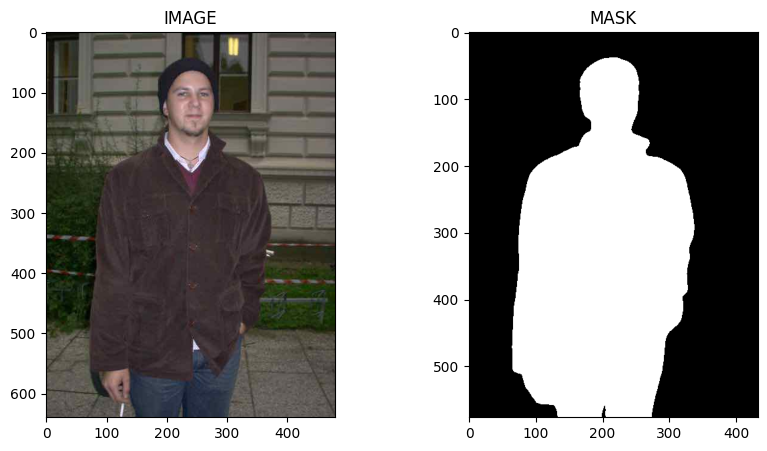

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [12]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 120)

In [13]:
import albumentations as A

def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes = 0)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ], is_check_shapes = 0)

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #h,w exist
    mask = np.expand_dims(mask, axis = -1) #now its h, w, c

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #h,w,c -> c,h,w (channel, height, weight)

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image, mask

In [16]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


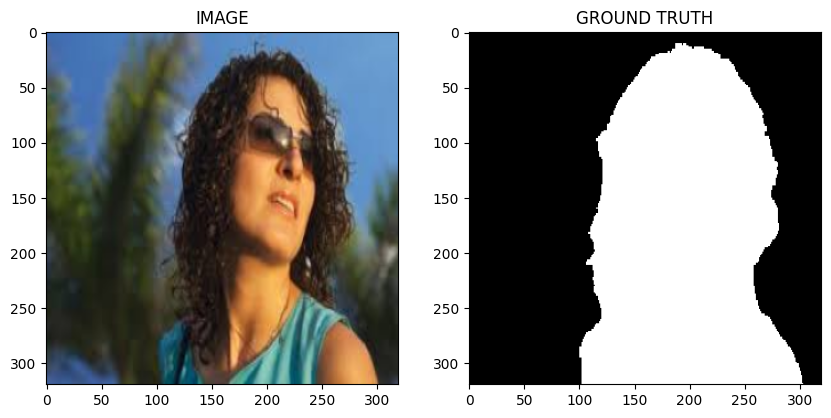

In [55]:
idx = 5

image, mask = trainset[idx]

helper.show_image(image, mask)

In [19]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE) # it will get mixed up.. ,

print(f"Number of trainloader is: {len(trainloader)}")
print(f"Number of validloader is: {len(validloader)}")

Number of trainloader is: 15
Number of validloader is: 4


In [20]:
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([3, 320, 320])
One batch mask shape: torch.Size([1, 320, 320])


In [ ]:
!pip install segmentation-models-pytorch

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks= None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [ ]:
model = SegmentationModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [25]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [26]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(data_loader):

      images = images.to(device)
      masks = masks.to(device)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss/len(data_loader)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'my-model.pt')
    print("Saved the model")
    best_valid_loss = valid_loss

  print(f"Epochs: {i+1} | Train Loss: {train_loss} | Validation Loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Saved the model
Epochs: 1 | Train Loss: 0.7074138661225636 | Validation Loss: 0.8625485002994537


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Saved the model
Epochs: 2 | Train Loss: 0.34973464012145994 | Validation Loss: 0.445494681596756


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Saved the model
Epochs: 3 | Train Loss: 0.2807756195465724 | Validation Loss: 0.26546841114759445


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epochs: 4 | Train Loss: 0.2512153814236323 | Validation Loss: 0.37119969725608826


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epochs: 5 | Train Loss: 0.2536670724550883 | Validation Loss: 0.3019082508981228


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Epochs: 6 | Train Loss: 0.236593034863472 | Validation Loss: 0.5311231464147568


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


Saved the model
Epochs: 7 | Train Loss: 0.22630377809206645 | Validation Loss: 0.232885904610157


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epochs: 8 | Train Loss: 0.23181359072526295 | Validation Loss: 0.3575100302696228


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epochs: 9 | Train Loss: 0.22050410409768423 | Validation Loss: 0.2638976350426674


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epochs: 10 | Train Loss: 0.18221287429332733 | Validation Loss: 0.38643668591976166


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Saved the model
Epochs: 11 | Train Loss: 0.18487915595372517 | Validation Loss: 0.21849073469638824


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Epochs: 12 | Train Loss: 0.16008391032616298 | Validation Loss: 0.22709345817565918


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


Saved the model
Epochs: 13 | Train Loss: 0.1490449473261833 | Validation Loss: 0.20286965370178223


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Saved the model
Epochs: 14 | Train Loss: 0.12814868688583375 | Validation Loss: 0.1933942399919033


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Saved the model
Epochs: 15 | Train Loss: 0.1167351966102918 | Validation Loss: 0.17248104140162468


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Saved the model
Epochs: 16 | Train Loss: 0.10193475286165873 | Validation Loss: 0.167264211922884


100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epochs: 17 | Train Loss: 0.1051005224386851 | Validation Loss: 0.20094313472509384


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epochs: 18 | Train Loss: 0.1359638551870982 | Validation Loss: 0.21907535195350647


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epochs: 19 | Train Loss: 0.20239714334408443 | Validation Loss: 0.4046355150640011


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

Epochs: 20 | Train Loss: 0.21284897724787394 | Validation Loss: 0.24671102315187454


In [37]:
idx = 50

model.load_state_dict(torch.load('/content/my-model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0)) # c,h,w -> 1,c,h,w

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

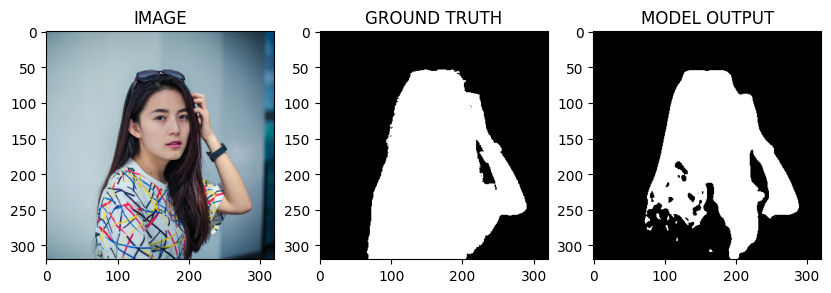

In [38]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))